# Analysis of the Sensitivity with respect to the Smothness Hyperparameter

## Preamble

In [1]:
import torch
import gpytorch
import numpy as np

%matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
from importlib.resources import files

from manifold_gp.kernels.riemann_matern_kernel import RiemannMaternKernel
from manifold_gp.models.riemann_gp import RiemannGP
from manifold_gp.utils.mesh_helper import groundtruth_from_samples
from manifold_gp.utils.file_read import get_data

## Dataset Preprocessing

### Load

In [2]:
data_path = files('manifold_gp.data').joinpath('dumbbell.msh')
data = get_data(data_path, "Nodes", "Elements")

vertices = data['Nodes'][:, 1:-1]
edges = data['Elements'][:, -2:].astype(int) - 1
truth, geodesics = groundtruth_from_samples(vertices,edges)

sampled_x = torch.from_numpy(vertices).float()
sampled_y = torch.from_numpy(truth).float()
(m, n) = sampled_x.shape

normalize_features = False
normalize_labels = True

### Noise

In [3]:
noise_sampled_x = 0.0
noisy_x = sampled_x + noise_sampled_x * torch.randn(m, n)

noise_sampled_y = 0.01
noisy_y = sampled_y + noise_sampled_y * torch.randn(m)

### Normalize

In [4]:
if normalize_features:
    mu_x, std_x = noisy_x.mean(dim=-2, keepdim=True), train_x.std(dim=-2, keepdim=True) + 1e-6
    noisy_x.sub_(mu_x).div_(std_x)
    
if normalize_labels:
    mu_y, std_y = noisy_y.mean(), noisy_y.std()
    noisy_y.sub_(mu_y).div_(std_y)

### Move Data to Device

In [5]:
noisy_x, noisy_y = noisy_x.contiguous(), noisy_y.contiguous()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
noisy_x, noisy_y = noisy_x.to(device), noisy_y.to(device)

## Model

In [6]:
%%capture
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-8),
    noise_prior=None  # NormalPrior(torch.tensor([0.0]).to(device),  torch.tensor([1/9]).sqrt().to(device))
)

kernel = gpytorch.kernels.ScaleKernel(
    RiemannMaternKernel(
        nu=4,
        nodes=noisy_x,
        neighbors=10,
        operator="randomwalk",
        modes=100,
        ball_scale=3.0,
        prior_bandwidth=False,
    ),
    outputscale_prior=None  # NormalPrior(torch.tensor([1.0]).to(device),  torch.tensor([1/9]).sqrt().to(device))
)

model = RiemannGP(noisy_x, noisy_y, likelihood, kernel).to(device)

hypers = {
    'likelihood.noise_covar.noise': 1e-2,
    'covar_module.base_kernel.epsilon': 0.5,
    'covar_module.base_kernel.lengthscale': 1.0,
    'covar_module.outputscale': 1.0,
}
model.initialize(**hypers)

## Train

In [7]:
model.manifold_informed_train(lr=1e-2, iter=100, 
                              decay_step_size=1000, decay_magnitude=1.0,
                              norm_step_size=10, norm_rand_vec=100, 
                              verbose=True, save=True)

Iter: 0, LR: 0.010, Loss: 68.392, NoiseVar: 0.010, SignalVar: 1724.655, Lengthscale: 1.000, Epsilon: 0.500
Iter: 1, LR: 0.010, Loss: 37.320, NoiseVar: 0.010, SignalVar: 1724.645, Lengthscale: 0.994, Epsilon: 0.496
Iter: 2, LR: 0.010, Loss: 6.892, NoiseVar: 0.010, SignalVar: 1724.635, Lengthscale: 0.987, Epsilon: 0.492
Iter: 3, LR: 0.010, Loss: -23.703, NoiseVar: 0.010, SignalVar: 1724.625, Lengthscale: 0.981, Epsilon: 0.488
Iter: 4, LR: 0.010, Loss: -57.061, NoiseVar: 0.010, SignalVar: 1724.615, Lengthscale: 0.975, Epsilon: 0.484
Iter: 5, LR: 0.010, Loss: -86.922, NoiseVar: 0.010, SignalVar: 1724.605, Lengthscale: 0.969, Epsilon: 0.481
Iter: 6, LR: 0.010, Loss: -117.946, NoiseVar: 0.009, SignalVar: 1724.595, Lengthscale: 0.963, Epsilon: 0.477
Iter: 7, LR: 0.010, Loss: -149.118, NoiseVar: 0.009, SignalVar: 1724.585, Lengthscale: 0.957, Epsilon: 0.473
Iter: 8, LR: 0.010, Loss: -173.314, NoiseVar: 0.009, SignalVar: 1724.575, Lengthscale: 0.951, Epsilon: 0.469
Iter: 9, LR: 0.010, Loss: -20

Iter: 75, LR: 0.010, Loss: -1965.437, NoiseVar: 0.004, SignalVar: 1724.016, Lengthscale: 0.935, Epsilon: 0.250
Iter: 76, LR: 0.010, Loss: -1993.498, NoiseVar: 0.004, SignalVar: 1724.005, Lengthscale: 0.937, Epsilon: 0.247
Iter: 77, LR: 0.010, Loss: -2051.568, NoiseVar: 0.004, SignalVar: 1723.995, Lengthscale: 0.938, Epsilon: 0.244
Iter: 78, LR: 0.010, Loss: -2087.225, NoiseVar: 0.004, SignalVar: 1723.984, Lengthscale: 0.940, Epsilon: 0.242
Iter: 79, LR: 0.010, Loss: -2128.348, NoiseVar: 0.004, SignalVar: 1723.974, Lengthscale: 0.941, Epsilon: 0.239
Iter: 80, LR: 0.010, Loss: -2160.940, NoiseVar: 0.004, SignalVar: 1723.963, Lengthscale: 0.943, Epsilon: 0.236
Iter: 81, LR: 0.010, Loss: -2211.090, NoiseVar: 0.004, SignalVar: 1723.952, Lengthscale: 0.945, Epsilon: 0.233
Iter: 82, LR: 0.010, Loss: -2241.412, NoiseVar: 0.004, SignalVar: 1723.941, Lengthscale: 0.946, Epsilon: 0.231
Iter: 83, LR: 0.010, Loss: -2270.838, NoiseVar: 0.004, SignalVar: 1723.931, Lengthscale: 0.948, Epsilon: 0.228
I

In [8]:
model.covar_module.outputscale.item()

0.08141789585351944

In [17]:
sum(p.numel() for p in model.parameters())

5

## Evaluation

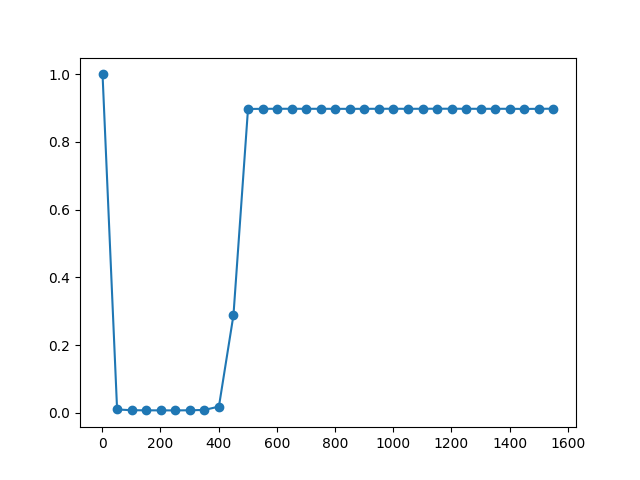

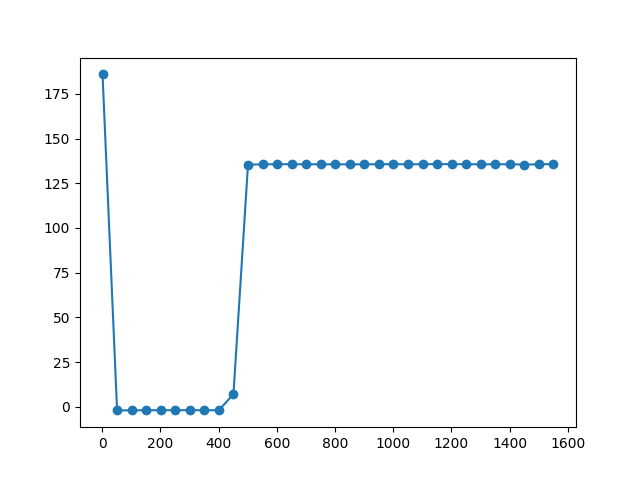

In [12]:
log_rmse = []
log_nll = []
for i in range(1,m,50):
    kernel.base_kernel.modes = i
    likelihood.eval()
    model.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds_test = likelihood(model(noisy_x))
        error = noisy_y - preds_test.mean
        covar = preds_test.lazy_covariance_matrix.evaluate_kernel()
        inv_quad, logdet = covar.inv_quad_logdet(inv_quad_rhs=error.unsqueeze(-1), logdet=True)

        log_rmse.append((error.square().sum()/noisy_y.shape[0]).sqrt().cpu())
        log_nll.append((0.5 * sum([inv_quad, logdet, error.size(-1)* np.log(2 * np.pi)])/noisy_y.shape[0]).cpu())
        model._clear_cache()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(1,m,50), np.array(log_rmse), '-o')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(1,m,50), np.array(log_nll), '-o')

In [10]:
np.argsort(np.array(log_nll))

array([ 2,  3,  1,  4, 13,  5, 12,  6, 11, 10,  7,  9,  8, 14, 15, 16, 17,
       42, 37, 19, 51, 49, 18, 45, 33, 21, 23, 41, 26, 38, 39, 35, 50, 47,
       27, 22, 34, 46, 20, 24, 44, 36, 30, 48, 28, 43, 32, 40, 31, 29, 25,
        0])

In [11]:
log_nll[2]

tensor(-2.0176)

In [12]:
np.arange(1,m,30)[3]

91

In [13]:
kernel.base_kernel.modes = 400

In [14]:
%%capture
likelihood.eval()
model.eval()

## Metrics

In [15]:
with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.max_cg_iterations(10000):
    preds_test = likelihood(model(noisy_x))
        
    error = noisy_y - preds_test.mean
    covar = preds_test.lazy_covariance_matrix.evaluate_kernel()
    inv_quad, logdet = covar.inv_quad_logdet(inv_quad_rhs=error.unsqueeze(-1), logdet=True)
    
    rmse = (error.square().sum()/noisy_y.shape[0]).sqrt()
    nll = 0.5 * sum([inv_quad, logdet, error.size(-1)* np.log(2 * np.pi)])/noisy_y.shape[0]
    model._clear_cache()
    
print("RMSE: ", rmse)
print("NLL: ", nll)

RMSE:  tensor(0.0063, device='cuda:0')
NLL:  tensor(-1.8777, device='cuda:0')


In [104]:
evecs = kernel.base_kernel.eigenvectors

In [105]:
kernel.base_kernel.eigenvalues

tensor([5.2587e-06, 2.7040e-02, 2.7068e-02, 1.0829e-01, 1.0836e-01, 2.4382e-01,
        2.4388e-01, 4.3327e-01, 4.3330e-01, 6.7684e-01, 6.7687e-01, 9.7443e-01,
        9.7445e-01, 1.3259e+00, 1.3259e+00, 1.7311e+00, 1.7311e+00, 2.1901e+00,
        2.1901e+00, 2.7026e+00, 2.7026e+00, 3.2684e+00, 3.2685e+00, 3.8876e+00,
        3.8876e+00, 4.5597e+00, 4.5598e+00, 5.2848e+00, 5.2848e+00, 6.0625e+00,
        6.0625e+00, 6.8926e+00, 6.8926e+00, 7.7750e+00, 7.7750e+00, 8.7092e+00,
        8.7093e+00, 9.6951e+00, 9.6952e+00, 1.0732e+01, 1.0733e+01, 1.1821e+01,
        1.1821e+01, 1.2960e+01, 1.2960e+01, 1.4150e+01, 1.4150e+01, 1.5389e+01,
        1.5389e+01, 1.6679e+01, 1.6679e+01, 1.8018e+01, 1.8018e+01, 1.9405e+01,
        1.9406e+01, 2.0842e+01, 2.0842e+01, 2.2327e+01, 2.2327e+01, 2.3859e+01,
        2.3859e+01, 2.5439e+01, 2.5439e+01, 2.7066e+01, 2.7066e+01, 2.8739e+01,
        2.8739e+01, 3.0458e+01, 3.0458e+01, 3.2222e+01, 3.2222e+01, 3.4031e+01,
        3.4031e+01, 3.5885e+01, 3.5885e+

In [106]:
kernel.base_kernel.spectral_density()

tensor([[2.6963e+00, 2.4720e+00, 2.4717e+00, 1.9437e+00, 1.9433e+00, 1.3750e+00,
         1.3748e+00, 9.2055e-01, 9.2050e-01, 6.0483e-01, 6.0480e-01, 3.9885e-01,
         3.9884e-01, 2.6712e-01, 2.6711e-01, 1.8261e-01, 1.8261e-01, 1.2764e-01,
         1.2763e-01, 9.1188e-02, 9.1188e-02, 6.6514e-02, 6.6512e-02, 4.9459e-02,
         4.9458e-02, 3.7431e-02, 3.7431e-02, 2.8788e-02, 2.8788e-02, 2.2468e-02,
         2.2467e-02, 1.7770e-02, 1.7770e-02, 1.4227e-02, 1.4226e-02, 1.1517e-02,
         1.1517e-02, 9.4184e-03, 9.4183e-03, 7.7743e-03, 7.7742e-03, 6.4724e-03,
         6.4724e-03, 5.4313e-03, 5.4312e-03, 4.5910e-03, 4.5909e-03, 3.9070e-03,
         3.9070e-03, 3.3459e-03, 3.3459e-03, 2.8822e-03, 2.8822e-03, 2.4964e-03,
         2.4963e-03, 2.1732e-03, 2.1732e-03, 1.9009e-03, 1.9009e-03, 1.6703e-03,
         1.6703e-03, 1.4738e-03, 1.4738e-03, 1.3057e-03, 1.3057e-03, 1.1611e-03,
         1.1611e-03, 1.0361e-03, 1.0361e-03, 9.2775e-04, 9.2775e-04, 8.3337e-04,
         8.3337e-04, 7.5085e

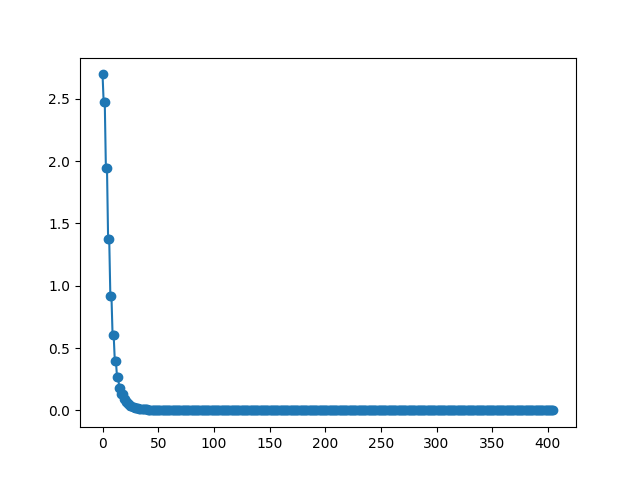

In [108]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(406), kernel.base_kernel.spectral_density().detach().cpu().squeeze(), '-o')


## Plot

In [ ]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    resolution = 100
    x, y = torch.meshgrid(torch.linspace(-1.5, 1.5, resolution), torch.linspace(-1.5, 1.5, resolution), indexing='xy')
    grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
    
    if normalize_features:
        preds_ambient = model(grid_x.sub(mu_x).div(std_x))
        noisy_x.mul_(std_x).add_(mu_x)
    else:
        preds_ambient = model(grid_x)

### Ground Truth

In [ ]:
with torch.no_grad():
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=sampled_y.cpu().numpy())  # vmin=-0.5, vmax=0.5
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Ground Truth')
    
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=posterior_mean_manifold.cpu().numpy())
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Posterior Mean')

In [ ]:
idx_ordered = np.array([edges[0,0],edges[0,1]])
tmp = np.delete(edges, 0, axis=0)
while idx_ordered.shape[0] != m:
    idx_next = np.where(np.any(tmp == idx_ordered[-1], axis=1))
    idx_ordered = np.append(idx_ordered,tmp[idx_next][0][0 if tmp[idx_next][0][1]==idx_ordered[-1] else 1])
    tmp = np.delete(tmp, idx_next, axis=0)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(m), truth[idx_ordered])

### Posterior Mean

In [ ]:
with torch.no_grad():
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=posterior_mean_manifold.cpu().numpy())
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Posterior Mean')

### Kernel Evaluation

In [ ]:
with torch.no_grad():
    k_base = kernel.base_kernel(noisy_x[0, :].unsqueeze(0), noisy_x[0, :].unsqueeze(0)).evaluate()
    kernel_eval_manifold = (kernel.base_kernel(noisy_x[0, :].unsqueeze(0), noisy_x).evaluate()/k_base).squeeze().cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=kernel_eval_manifold)
    ax.scatter(noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1], c='r', s=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Kernel Evaluation')

### Features

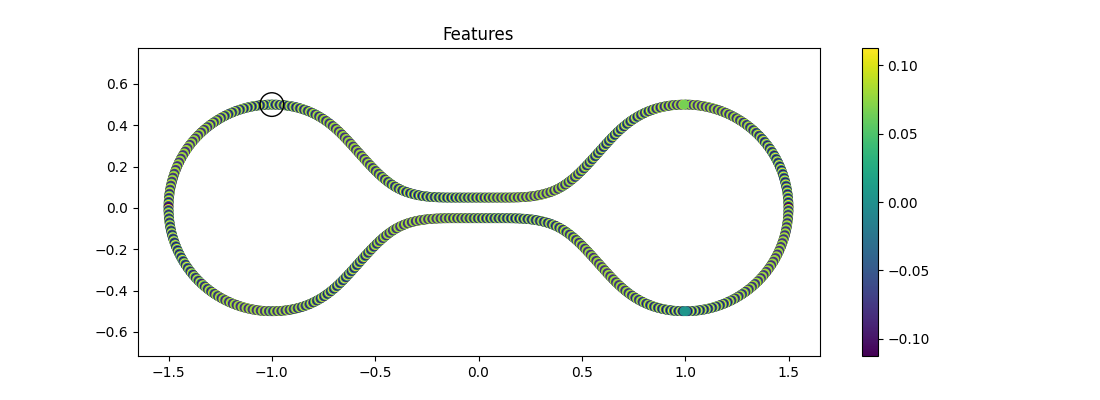

In [76]:
with torch.no_grad():
    c = 1.0
#     l_features = kernel.base_kernel.features(noisy_x, c=c)[:,1].cpu().numpy()
    e_features = kernel.base_kernel.eigenvectors[:,405].cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=e_features)
    circle = plt.Circle((noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1]), 
                        c*kernel.base_kernel.epsilon.cpu().numpy(), color='k', fill=False)
    ax.add_patch(circle)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Features')

### Prior Variance

In [ ]:
model.covar_module.outputscale

In [ ]:
with torch.no_grad():
    prior_var_manifold = model.covar_module(noisy_x, noisy_x, diag=True).cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=prior_var_manifold)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Prior Variance')

### Posterior Standard Deviation

In [ ]:
with torch.no_grad():
    posterior_std_manifold = preds_manifold.stddev.cpu().numpy()
    fig = plt.figure(figsize=(11, 4))
    ax = fig.add_subplot(111)
    plot = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=posterior_std_manifold)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Standard Deviation')

### Ambient Posterior Mean

In [ ]:
with torch.no_grad():
    if normalize_labels:
        posterior_mean_ambient = preds_ambient.mean.mul(std_y).add(mu_y).cpu().numpy()
    else:
        posterior_mean_ambient = preds_ambient.mean.cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), posterior_mean_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), posterior_mean_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Posterior Mean')

### Ambient Kernel Evaluation

In [ ]:
with torch.no_grad():
    kernel_eval_ambient = model.covar_module(noisy_x[0, :].unsqueeze(0), grid_x).evaluate().squeeze().cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), kernel_eval_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), kernel_eval_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    ax.scatter(noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1], c='r', s=1.0)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Kernel Evaluation')

### Ambient Features

In [ ]:
from torch_geometric.nn import radius

with torch.no_grad():
    test_idx, train_idx = radius(kernel.base_kernel.nodes, grid_x, c*kernel.base_kernel.epsilon, 
                                 max_num_neighbors=kernel.base_kernel.nodes.shape[0])
    c = 1.0
    features_grid = kernel.base_kernel.features(grid_x, c=c)[:,1].cpu().numpy()
#     features_grid = kernel.base_kernel.inverse_distance_weighting(grid_x, kernel.base_kernel.eigenvectors, train_idx, test_idx)[:,1].cpu().numpy()
#     features_grid = kernel.base_kernel.locally_weighted_regression(grid_x, kernel.base_kernel.eigenvectors, train_idx, test_idx, s=0.01)[:,1].cpu().numpy()
#     features_grid = kernel.base_kernel.nystrom_formula(grid_x, noisy_x, kernel.base_kernel.eigenvectors, s = 0.01)[:,1].cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), features_grid.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), posterior_sample_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    circle = plt.Circle((noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1]), 
                        c*kernel.base_kernel.epsilon.cpu().numpy(), color='k', fill=False)
    ax.add_patch(circle)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Features')

### Ambient Prior Variance

In [ ]:
with torch.no_grad():
    prior_var_ambient = model.covar_module(grid_x, grid_x, diag=True).cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), prior_var_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), prior_var_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Prior Variance')

### Ambient Posterior Standard Deviation

In [ ]:
with torch.no_grad():
    posterior_std_ambient = preds_ambient.stddev.cpu().numpy()
    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111)
    contour = ax.contourf(x.cpu(), y.cpu(), posterior_std_ambient.reshape(resolution, -1), 500)
    # ax.contour(x.cpu(), y.cpu(), posterior_std_grid.reshape(resolution, -1), 10, cmap=None, colors='#f2e68f')
    ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c='k', s=0.5)
    fig.colorbar(contour)
    ax.axis('square')
    ax.set_title('Standard Deviation')